In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [91]:
online_shoppers = pd.read_csv('online_shoppers_intention.csv')
online_shoppers.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Machine Learning Phase

- Categorical  Encodings

In [92]:
from sklearn.preprocessing import LabelEncoder
df = online_shoppers.copy()

for col in df.select_dtypes('object'):
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

- Here we check the Multi-colinearity between the columns

- There are some Outliers in our columns we will try to detect them Using The IQR method

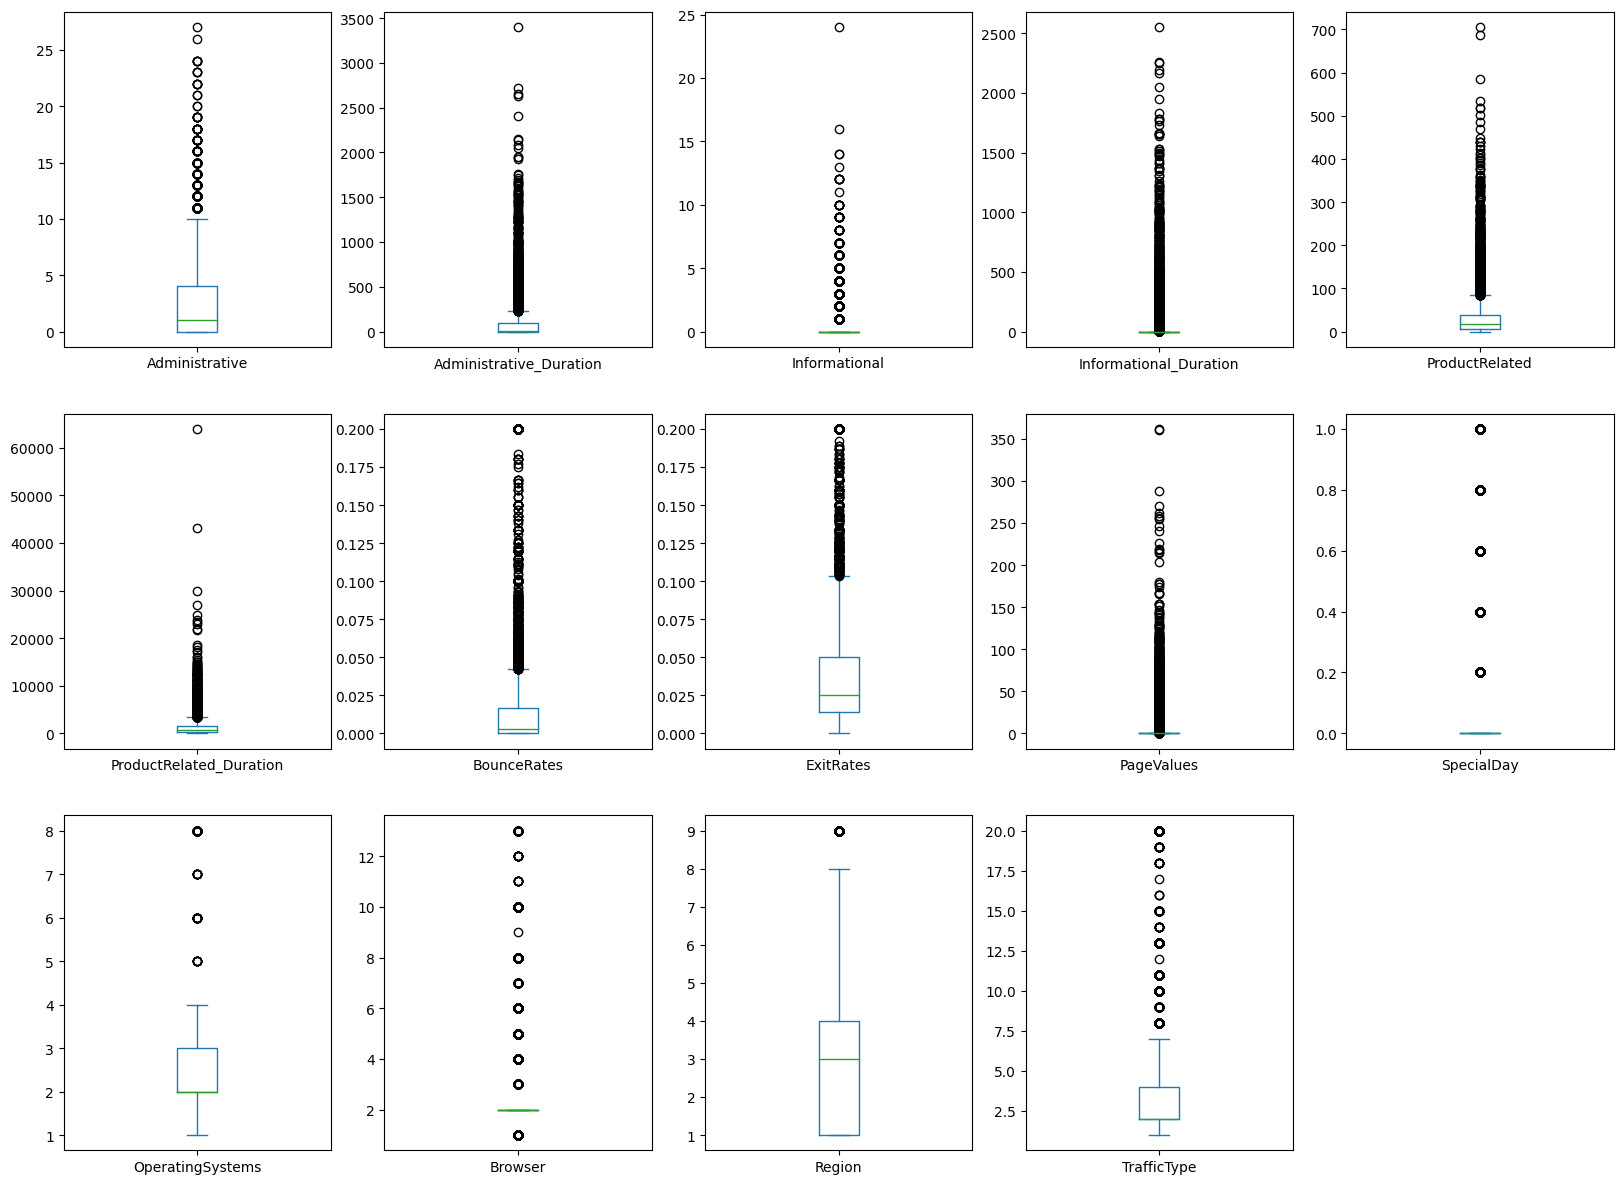

In [93]:
numerical_data = online_shoppers.select_dtypes(exclude='object')
numerical_data.plot(kind='box', subplots=True,\
                    sharex=False, sharey=False,\
                    figsize=(20, 20),  layout=(4, 5))

plt.savefig('figs/Box Plots.png', format='png')

- Getting the indecies of the outliers. I can't Drop all the outliers because the it contains 25 y-yes values so we may drop the y-no rows but keeping the y-yes rows.

In [94]:
q3, q1 = np.percentile(df['BounceRates'], [75, 25])
print(q3, q1)
print(len(df))

IQR = q3 - q1
print(IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR

0.016812558499999998 0.0
12330
0.016812558499999998


In [95]:
mask1 = df['BounceRates'] > upper_bound
mask2 = df['BounceRates'] < lower_bound

outliers_indecies = df[(mask1) | (mask2)].index

len(outliers_indecies)

1551

In [96]:
df.loc[outliers_indecies]['Revenue'].value_counts()

False    1526
True       25
Name: Revenue, dtype: int64

In [97]:
df.corr()['Revenue']

Administrative             0.138917
Administrative_Duration    0.093587
Informational              0.095200
Informational_Duration     0.070345
ProductRelated             0.158538
ProductRelated_Duration    0.152373
BounceRates               -0.150673
ExitRates                 -0.207071
PageValues                 0.492569
SpecialDay                -0.082305
Month                      0.080150
OperatingSystems          -0.014668
Browser                    0.023984
Region                    -0.011595
TrafficType               -0.005113
VisitorType               -0.104726
Weekend                    0.029295
Revenue                    1.000000
Name: Revenue, dtype: float64

- Handling the imbalanced target variable.

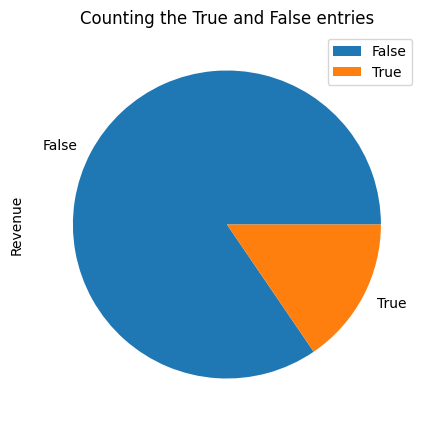

In [98]:
df['Revenue'].value_counts().plot.pie(figsize=(10, 5))
plt.legend()
plt.title('Counting the True and False entries')
plt.savefig('figs/Counting the Yes and No entries.png', format='png')
plt.show()

In [99]:
from imblearn.over_sampling import RandomOverSampler

X =  df.drop('Revenue', axis=1)
y = df['Revenue'].replace({False:0, True:1})

rus = RandomOverSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y)

-  After  the random under sampling

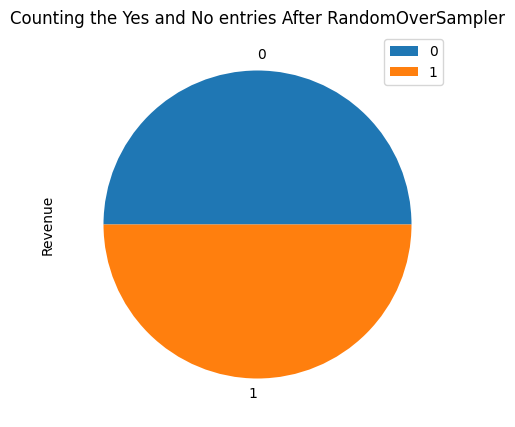

In [100]:
y_res.value_counts().plot.pie(figsize=(10, 5))
plt.legend()
plt.title('Counting the Yes and No entries After RandomOverSampler')
plt.savefig('figs/Counting the Yes and No entries After RandomOverSampler.png', format='png')
plt.show()

Knn 0.8570811132713857 0.004275152313704178
Dtc 0.9520727432944653 0.0033292923939404733
Rdf 0.9635386678661485 0.0017626490062073333
adb 0.8470544978497262 0.004559052391867713
grdb 0.869794857298339 0.0025713162579840193
Gaus 0.7502880229681744 0.004152744273235631
LDA 0.7766264826438076 0.004472489980211577
LogR 0.8080503018117915 0.00248810644258582


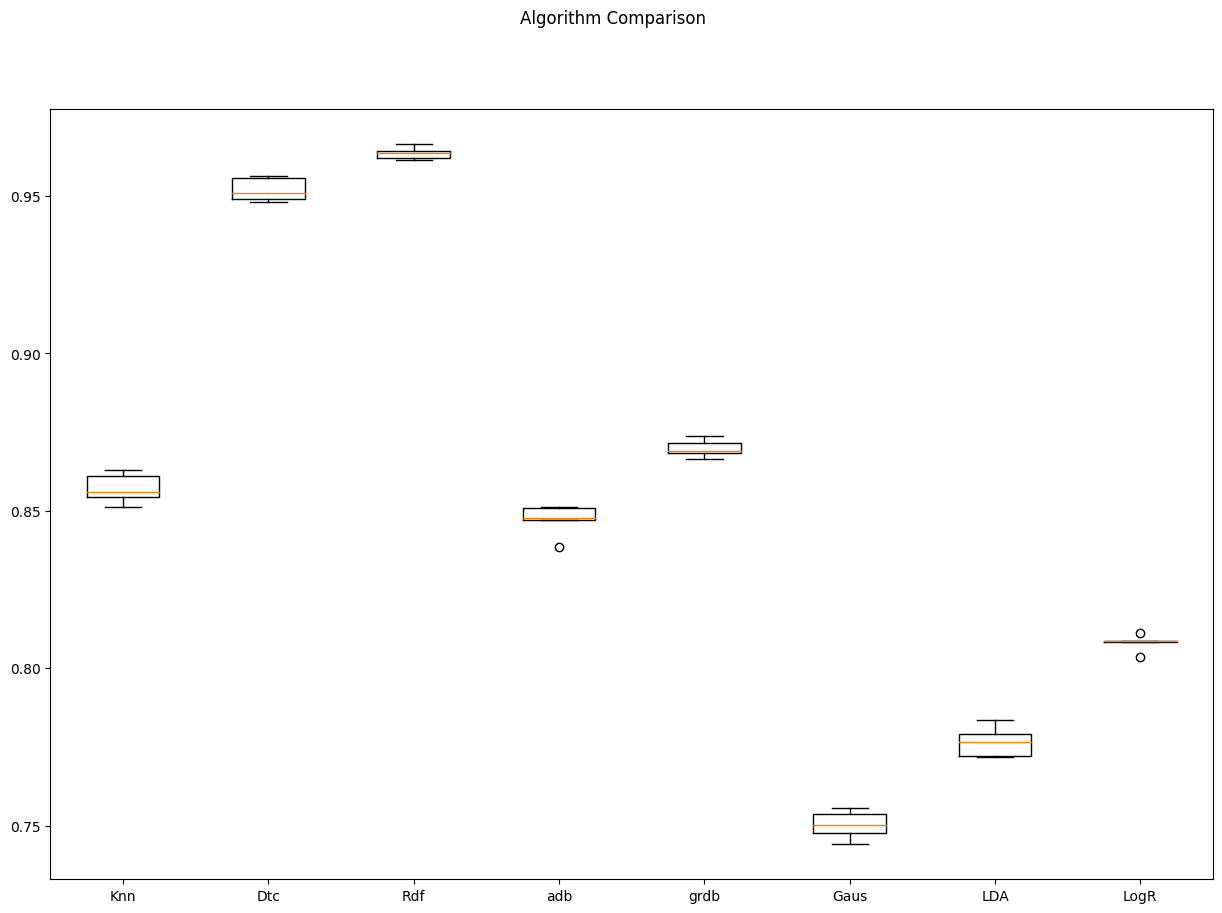

In [101]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score

models = [
    ('Knn', KNeighborsClassifier()),
    # ('svc', SVC()),
    ('Dtc', DecisionTreeClassifier()),
    ('Rdf', RandomForestClassifier()),
	('adb', AdaBoostClassifier()),
    ('grdb', GradientBoostingClassifier()),
    ('Gaus', GaussianNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('LogR', LogisticRegression(max_iter=1000)),
    # ('MLP', MLPClassifier(max_iter=1000))
]
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, X_res, y_res, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(name, cv_results.mean(), cv_results.std())
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('figs/Models Comparison.png',  format='png')
plt.show()

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, random_state=0)

model = RandomForestClassifier()

model.fit(X_train, y_train)
pred = model.predict(X_test)

In [103]:
from  sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Evaluating the model with the Classification Metrics

CM_RF = confusion_matrix(y_test, pred)
CR_RF = classification_report(y_test, pred)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, pred)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}
# Showing the results of the model
for measure in resultsRF:
    print(measure,": \n", resultsRF[measure])

Confusion Matrix : 
 [[ 952   77]
 [   2 1054]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      1029
           1       0.93      1.00      0.96      1056

    accuracy                           0.96      2085
   macro avg       0.96      0.96      0.96      2085
weighted avg       0.96      0.96      0.96      2085

Area Under Curve : 
 0.9616380643166357


In [104]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [105]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9621103117505995
